# 固定効果推定の残差

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import statsmodels.api as sm
from patsy import dmatrices
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')

figsize = (10, 5)

In [47]:
path = '../../data/processed/df_filtered.xlsx'
df = pd.read_excel(path)
df = df.dropna(subset=['population'])

# 島をカテゴリ化
df.island_ids = df.island_ids.astype(str)
df.island_ids = df.island_ids.map(str.strip)
island_ids, mn_island_ids = df.island_ids.factorize()
df.year = df.year.astype(str)
df.year = df.year.map(str.strip)
year, mn_years = df.year.factorize()

## 固定効果推定

In [18]:
# 頻度論
y, X = dmatrices('log_pop ~ after_treatment + C(island_ids) + C(year)', data=df, return_type='dataframe')
model = sm.OLS(y, X)
result = model.fit(cov_type='cluster', cov_kwds={'groups': df['island_ids']})
print(result.summary())
y_pred = result.predict(X)
residual = df['log_pop'] - y_pred

                            OLS Regression Results                            
Dep. Variable:                log_pop   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                -2.908e+14
Date:                Thu, 09 Jan 2025   Prob (F-statistic):               1.00
Time:                        00:37:02   Log-Likelihood:                 184.87
No. Observations:                1615   AIC:                            -147.7
Df Residuals:                    1504   BIC:                             450.2
Df Model:                         110                                         
Covariance Type:              cluster                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                4.5892 

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 110, but rank is 29
  warnings.warn('covariance of constraints does not have full '


Text(0.5, 0, 'Residual')

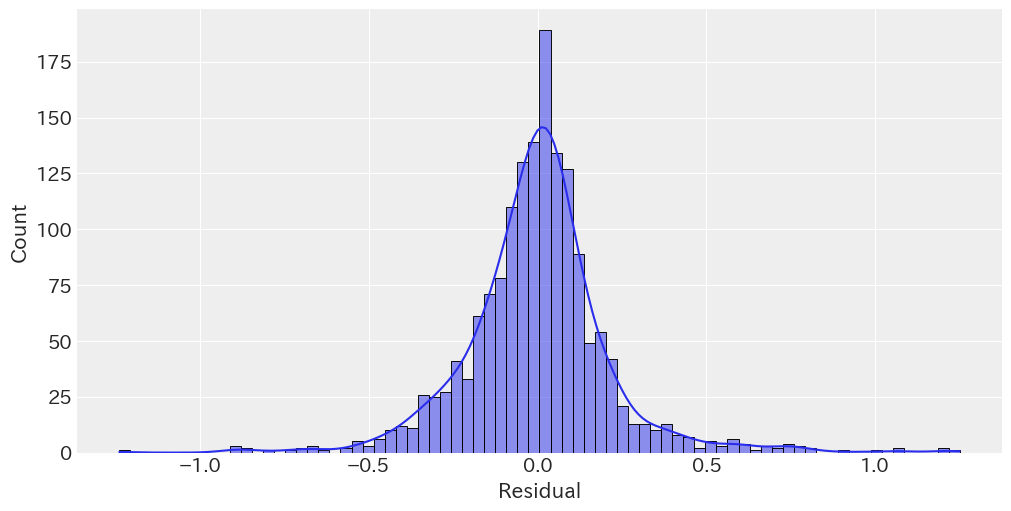

In [19]:
fig, ax = plt.subplots(figsize=figsize)
sns.histplot(residual, kde=True, ax=ax)
ax.set_xlabel('Residual')

In [32]:
y, X = dmatrices('log_pop ~ treatment_group:C(time_since_treatment) + C(island_ids) + C(year) - 1', data=df, return_type='dataframe')
model = sm.OLS(y, X)
result = model.fit(cov_type='cluster', cov_kwds={'groups': df['island_ids']})
print(result.summary())
y_pred = result.predict(X)
residual = df['log_pop'] - y_pred

                            OLS Regression Results                            
Dep. Variable:                log_pop   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 09 Jan 2025   Prob (F-statistic):                nan
Time:                        00:41:59   Log-Likelihood:                 316.26
No. Observations:                1615   AIC:                            -236.5
Df Residuals:                    1417   BIC:                             830.1
Df Model:                         197                                         
Covariance Type:              cluster                                         
                                                   coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

In [52]:
params = result.params
std_err = result.bse
conf_int = result.conf_int()

# データフレームに格納
dynamic_results = pd.DataFrame({
    'Estimate': params.values,
    'Std_Err': std_err.values,
    'CI_Lower': conf_int[0],
    'CI_Upper': conf_int[1]
})


,Estimate,Std_Err,CI_Lower,CI_Upper
C(island_ids)[101],4.661322,0.120592,4.424966,4.897678
C(island_ids)[103],1.920359,0.078142,1.767204,2.073515
C(island_ids)[104],6.753208,0.097080,6.562936,6.943481
C(island_ids)[105],4.917663,0.120592,4.681307,5.154019
C(island_ids)[106],6.443136,0.122539,6.202964,6.683309
...,...,...,...,...
treatment_group:C(time_since_treatment)[47],2.941121,0.150999,2.645169,3.237073
treatment_group:C(time_since_treatment)[48],3.355691,0.116626,3.127108,3.584275
treatment_group:C(time_since_treatment)[49],2.742220,0.146253,2.455568,3.028871
treatment_group:C(time_since_treatment)[50],2.702356,0.139362,2.429211,2.975501


In [55]:
dynamic_results = pd.read_csv('./dynamic_results_classical.csv')

In [58]:
tst = df.time_since_treatment.unique()
tst.sort()
tst

array([-46, -45, -41, -40, -36, -35, -34, -33, -31, -30, -29, -28, -26,
       -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13,
       -12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,
         1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  47,  48,  49,  50,  55])

In [59]:
dynamic_results['time_since_treatment'] = tst

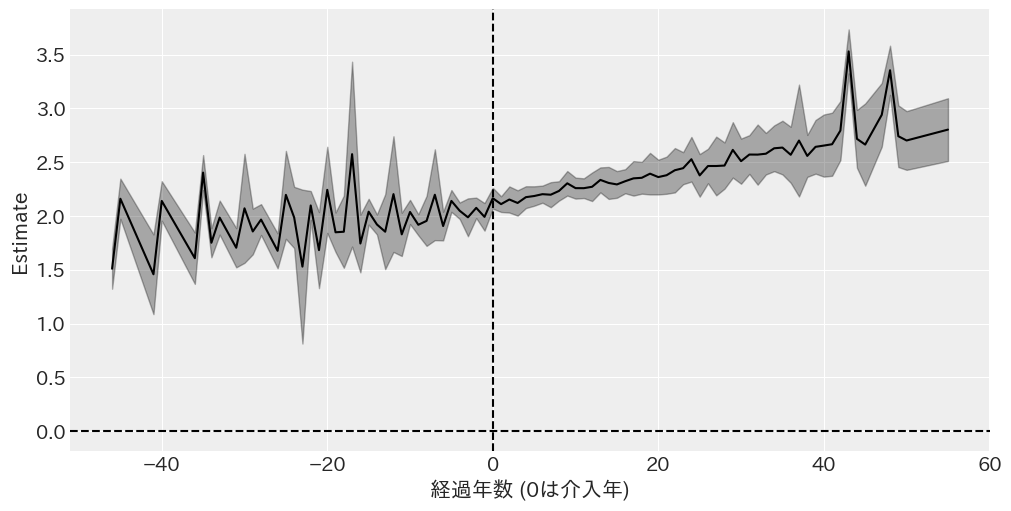

In [67]:
fig, ax = plt.subplots(figsize=figsize)
sns.lineplot(x='time_since_treatment', y='Estimate', data=dynamic_results, ax=ax, color='black')
ax.fill_between(dynamic_results['time_since_treatment'], dynamic_results['CI_Lower'], dynamic_results['CI_Upper'], alpha=0.3, color='black')
ax.set_xlabel('経過年数 (0は介入年)')
ax.set_ylabel('Estimate')
ax.axvline(x=0, color='black', linestyle='--')
ax.axhline(y=0, color='black', linestyle='--')

In [68]:
y, X = dmatrices('log_pop ~ treatment_group:C(bridge_year):C(time_since_treatment) + C(island_ids) + C(year) - 1', data=df, return_type='dataframe')
model = sm.OLS(y, X)
result = model.fit(cov_type='cluster', cov_kwds={'groups': df['island_ids']})
print(result.summary())
y_pred = result.predict(X)
residual = df['log_pop'] - y_pred

In [70]:
params = result.params
std_err = result.bse
conf_int = result.conf_int()

# データフレームに格納
fully_saturated_results = pd.DataFrame({
    'Estimate': params.values,
    'Std_Err': std_err.values,
    'CI_Lower': conf_int[0],
    'CI_Upper': conf_int[1]
})


In [72]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                log_pop   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 09 Jan 2025   Prob (F-statistic):                nan
Time:                        00:57:08   Log-Likelihood:                 489.74
No. Observations:                1615   AIC:                            -9.486
Df Residuals:                    1130   BIC:                             2603.
Df Model:                         484                                         
Covariance Type:              cluster                                         
                                                                        coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------

## Bayes

In [54]:
COORDS = {'y': df.index, 'X': df.index, 'island_id': mn_island_ids, 'year': mn_years}

with pm.Model(coords=COORDS) as model:
    # data
    log_pop = pm.Data('log_pop', df['log_pop'], dims='y')

    # priors
    # random effects
    sigma = pm.HalfCauchy('sigma', beta=1)

    # fixed effects
    mu_island = pm.Normal('mu_island', mu=5, sigma=1)
    sigma_island = pm.HalfNormal('sigma_island', 1)
    island_raw = pm.Normal('island_raw', mu=0, sigma=5, dims='island_id')
    island_effect = pm.Deterministic('island_effect', mu_island + sigma_island * island_raw, dims='island_id')

    mu_year = pm.Normal('mu_year', mu=-0.5, sigma=1)
    sigma_year = pm.HalfNormal('sigma_year', 0.5)
    year_raw = pm.Normal('year_raw', mu=0, sigma=1, dims='year')
    year_effect = pm.Deterministic('year_effect', mu_year + sigma_year * year_raw, dims='year')

    nu = pm.Gamma('nu', alpha=2, beta=0.1)

    # expectation
    mu = island_effect[island_ids] + year_effect[year]

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=nu, mu=mu, sigma=sigma, observed=log_pop)

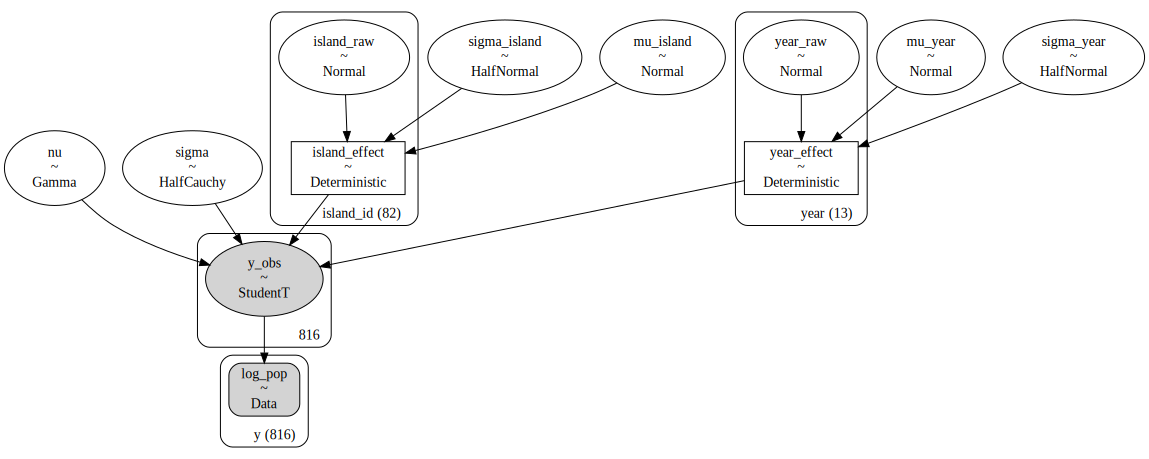

In [55]:
pm.model_to_graphviz(model)

In [56]:
with model:
    trace = pm.sample(
        draws=2000,
        tune=2000,
        chains=4,
        cores=4,
        target_accept=.9,
        nuts_sampler='numpyro'
    )

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


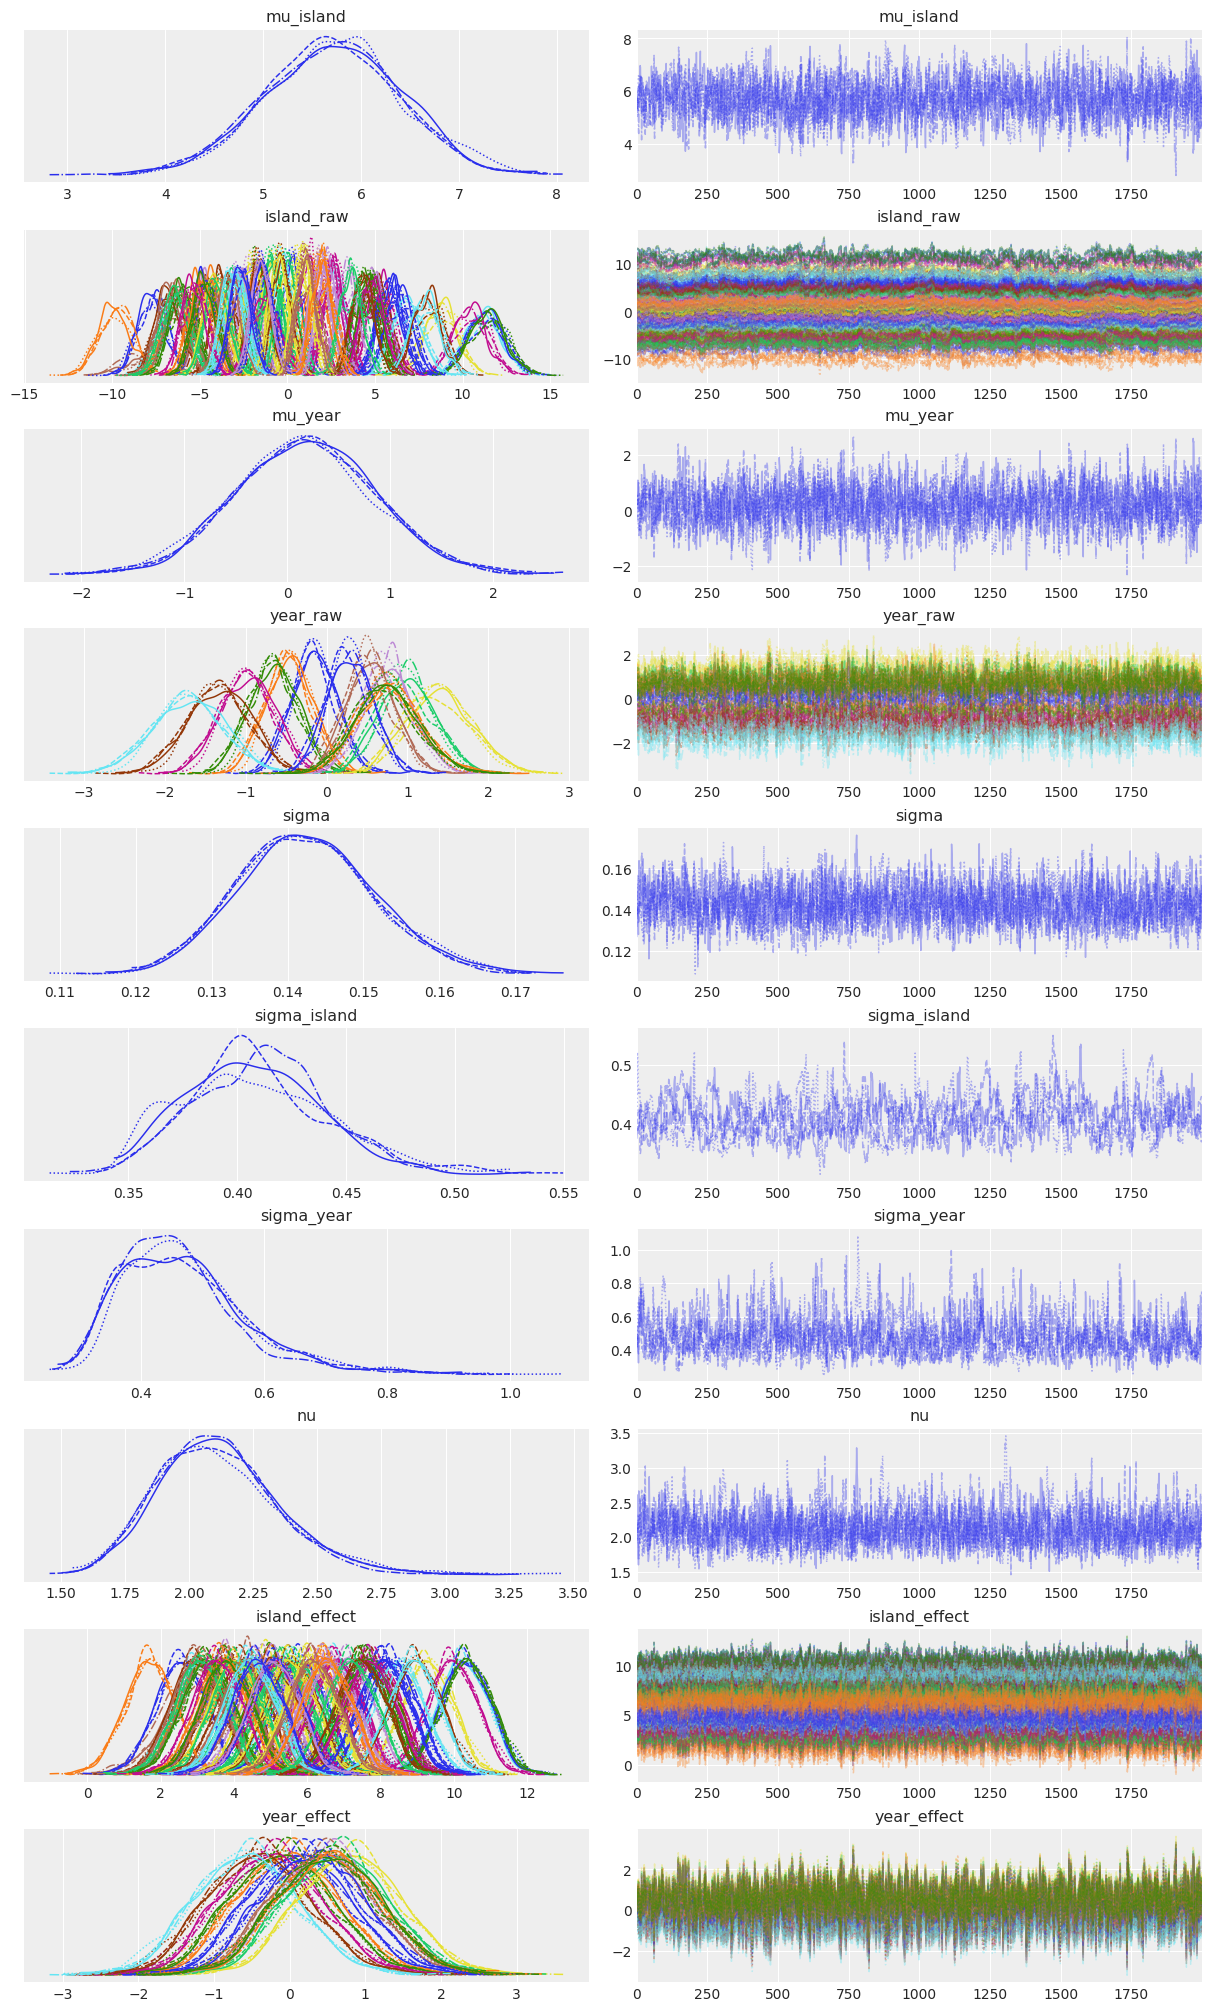

In [57]:
az.plot_trace(trace, compact=True);

In [58]:
with model:
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

Sampling: [y_obs]


Output()

(0.0, 13.0)

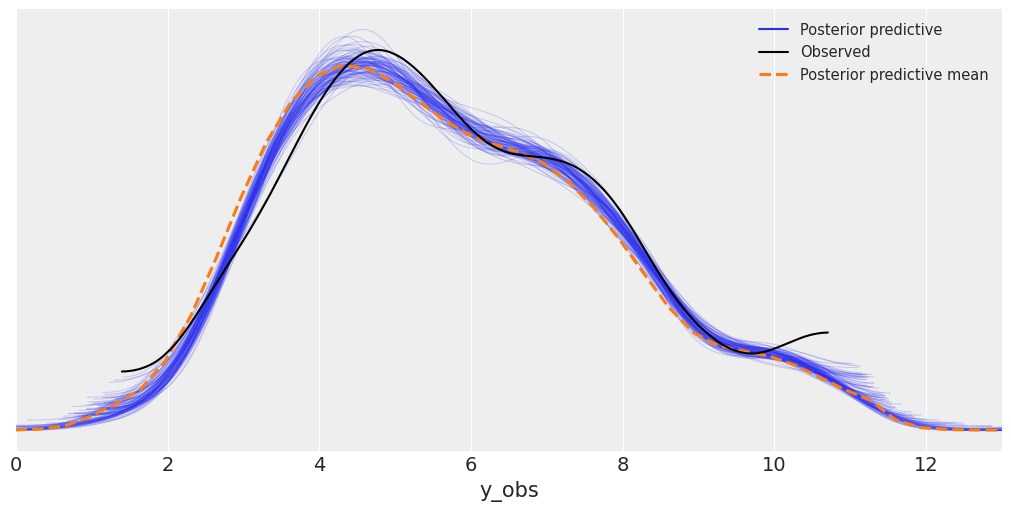

In [59]:
fig, ax = plt.subplots(figsize=figsize)
az.plot_ppc(trace, num_pp_samples=100, ax=ax)
ax.set_xlim(0, 13)

In [60]:
residuals = df['log_pop'] - y_pred

Text(0, 0.5, '')

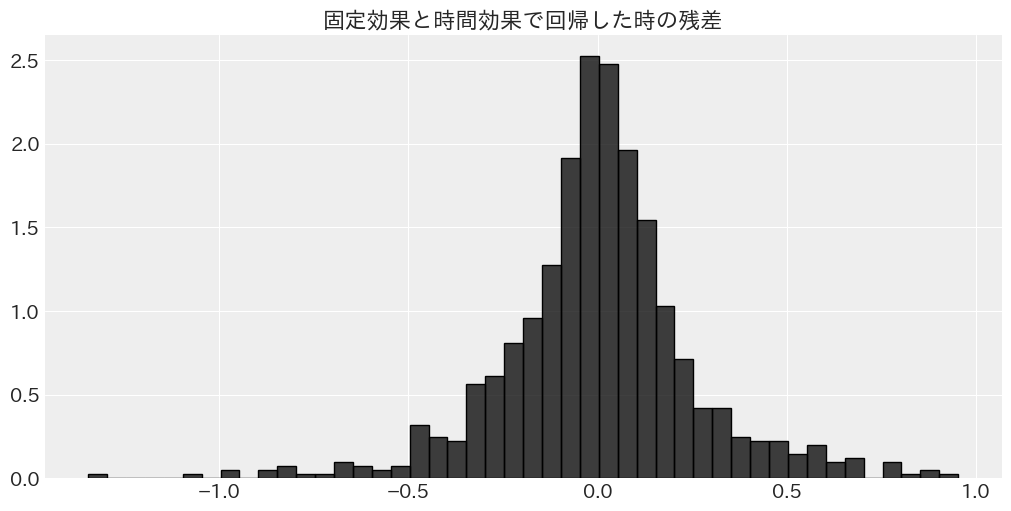

In [71]:
fig, ax = plt.subplots(figsize=figsize)
sns.histplot(residuals, ax=ax, color='black', stat='density')
ax.set_title('固定効果と時間効果で回帰した時の残差')
ax.set_xlabel('')
ax.set_ylabel('')

In [72]:
az.to_netcdf(trace, './mcmc_sample/fixed_effect_residuals.nc')

'./mcmc_sample/fixed_effect_residuals.nc'